<a href="https://colab.research.google.com/github/MAnn223/FutureMakers2022/blob/main/Day_12_Image_Classification_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

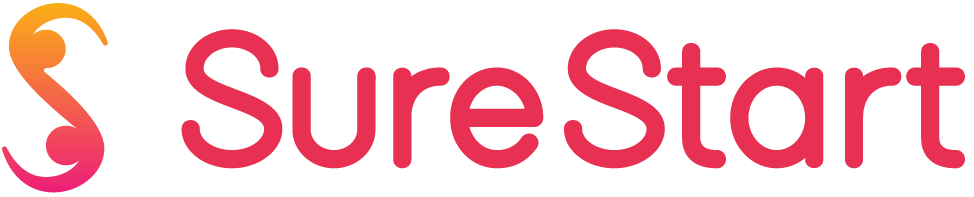

#Day 12 Objectives:
* To learn how to perform Image Classification using Machine Learning.


#Image Classification

Deep neural networks are the go to algorithm when it comes to image classification. This is partly because they can have arbitrarily large number of trainable parameters. However, this comes at a cost of requiring a large amount of data, which is sometimes not available.

Standard classification is what nearly all classification models use. The input is fed into a series of layers, and in the end, the class probabilities are output. If you want to predict dogs from cats, you train the model on similar(but not same) dogs/cats pictures that you would expect during prediction time. Naturally, this requires that you have a dataset that is similar to what you would expect once you use the model for prediction.

One Shot Classification models, on the other hand, requires that you have just one training example of each class you want to predict on. The model is still trained on several instances, but they only have to be in the similar domain as your training example.

A nice example would be facial recognition. You would train a One Shot classification model on a dataset that contains various angles, lighting, etc. of a few people. Then if you want to recognise if a person X is in an image, you take one single photo of that person, and then ask the model if that person is in the that image(note, the model was not trained using any pictures of person X).

As humans, we can recognize a person by his/her face by just meeting them once, and the same is desirable by computers because many times data is at a minimum.

We have had data which easily fits in our RAM and we did not need to deal with data loaders. Lets see how one would access data from a file directory to pass to a neural network.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# "Dogs vs. Cats" Dataset

There are many ways to download a dataset. One way is to download it from the Kaggle API as is covered in a Day 4 bonus content.

But we may need to download it manually in practice.

So let's start by downloading our example data, a .zip of 25,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.



In [2]:
! wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-07-24 22:01:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.68.33, 2600:1408:c400:e90::e59, 2600:1408:c400:e85::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.68.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   162MB/s    in 4.9s    

2022-07-24 22:02:02 (159 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



When we see the number of images per classification we should have around 12,500 images, but they are not separated into training sets and validation sets. So we should separate that ourselves.

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


First step towards the same is to create the directories for these segments in the dataset. 

We create training and test folders and respective folders per class in them.

In [4]:
! rm -rf /tmp/cats-and-dogs.zip

In [5]:
try:
    os.mkdir('/tmp/cats-and-dogs')
    os.mkdir('/tmp/cats-and-dogs/train')
    os.mkdir('/tmp/cats-and-dogs/test')
    os.mkdir('/tmp/cats-and-dogs/train/cats')
    os.mkdir('/tmp/cats-and-dogs/train/dogs')
    os.mkdir('/tmp/cats-and-dogs/test/cats')
    os.mkdir('/tmp/cats-and-dogs/test/dogs')
except OSError:
    pass

`split_data` function separates data into training and validation sets.

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-and-dogs/train/cats/"
TESTING_CATS_DIR = "/tmp/cats-and-dogs/test/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-and-dogs/train/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-and-dogs/test/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


The contents of the .zip are extracted to the base directory `/tmp/PetImages`, which contains `Cat` and `Dog` subdirectories. Let's define each of these directories:

In [7]:
base_dir = '/tmp/cats-and-dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Question 1
Why would we load the cats-and-dogs dataset via its directory path for the data and load chunks of it into memory? 

As opposed to loading the data fully into memory and accessing it via a Python data-structure. 

##Answer
We do this so we don't fill up the memory with the data and we still have space.

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [8]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['10051.jpg', '200.jpg', '1217.jpg', '9390.jpg', '1539.jpg', '9123.jpg', '80.jpg', '5210.jpg', '9813.jpg', '11071.jpg']
['1.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg']


Let's find out the total number of cat and dog images in the `train` and `test` directories:

In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 11250
total training dog images: 11250
total validation cat images: 1250
total validation dog images: 1250


For both cats and dogs, we have 11,250 training images and 1,250 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

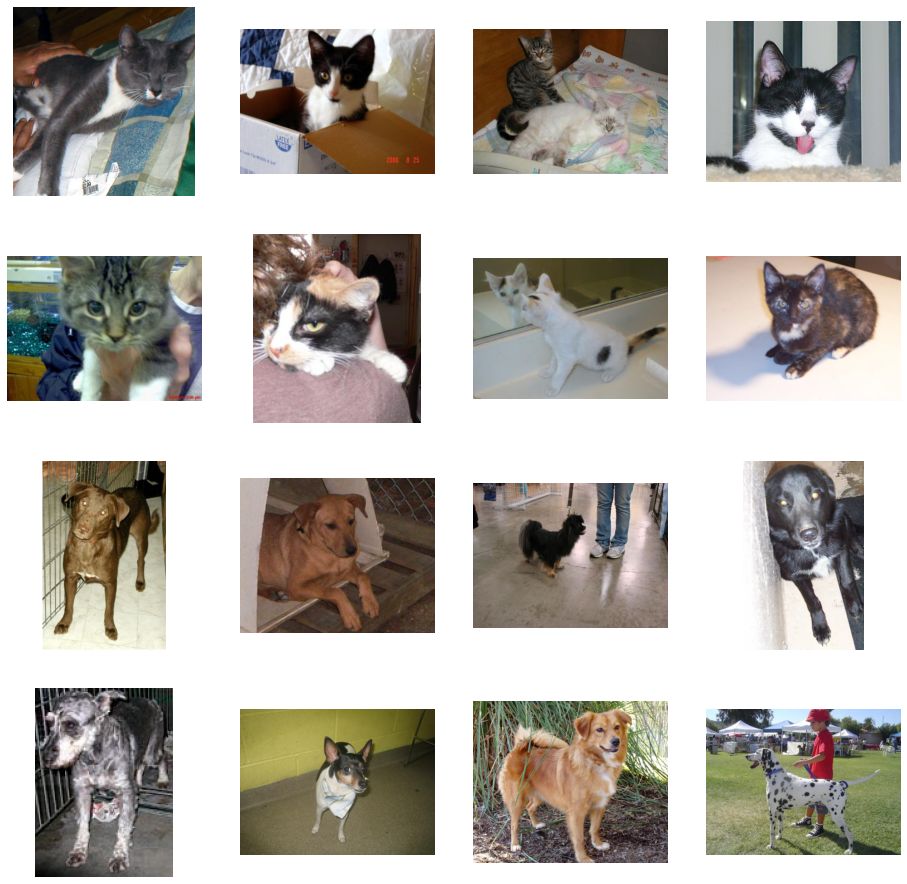

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Data Preprocessing

## Question 2

The images that will go into your net are all different shapes of color images (in this section on Data Preprocessing, you can add handling to resize all the images to n x n before feeding them into the neural network).

Write code to process these cats and dogs images to be able to feed them into your neural network, and normalize them.

*Note*: TensorFlow has a module called `ImageDataGenerator` which can be used for data preprocessing.

In [12]:
data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

#Fun Fact
Did you know the whole meaning of the term CAPTCHA? There is no doubt that most people who use the internet come across it most of the time when using the internet. “Completely Automated Public Turing Test to tell Computer and Humans Apart “is the meaning of the term CAPTCHA. Although the creators of the concepts intended to differentiate between humans and machines, artificial intelligence has surpassed it.

# Building your own neural net 

## Question 3

Let's code the model architecture. You can stack any number of {convolution + relu + maxpooling} modules. 

You need to define 
1. model hyperparameters (`model = tf.keras.models.Sequential([...])`)
2. loss functions and optimizers (`model.complie = (tf.keras.optimizers...)`)
3. training parameters (`model.fit()`)

### Answer 3

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3)),
  tf.keras.layers.ReLU(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3)),
  tf.keras.layers.ReLU(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(20, activation='softmax')
  
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_dogs_dir, train_cats_dir, epochs=20, validation_data=(validation_cats_dir, validation_dogs_dir))

IndexError: ignored

In [13]:
import tensorflow as tf

Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples, using just three convolutional modules keeps the model small, which lowers the risk of overfitting.

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

:Let's summarize the model architecture:

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 re_lu_9 (ReLU)              (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)       

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

## Training
Let's train on all 22,498 images available, for 15 epochs; and validate on all 2,500 validation images. (This may take a few minutes to run.)

In [19]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 22,498 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 2,500 images = batch_size * steps
      verbose=1)

NameError: ignored

# Visualizing Intermediate Representations

## Question 4

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map.

### Answer 4

In [20]:
def visualize_activation(model,activations,activation_model):
  layer_names = []
  for layer in model.layers[0:9]:
      layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
      
  images_per_row = 16

  for layer_name, layer_activation in zip(layer_names, activations):       # Displays the feature maps
      n_features = layer_activation.shape[-1]                              # Number of features in the feature map
      size = layer_activation.shape[1]                                     # The feature map has shape (1, size, size, n_features).
      n_cols = n_features // images_per_row                                # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols):                                            # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0, :, :, col * images_per_row + row]
              channel_image -= channel_image.mean()                        # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

visualize_activation(model,activations,activation_model)

NameError: ignored

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

# Evaluating Accuracy and Loss for the Model


## Question 5

Let's plot the training/testing accuracy and loss as collected during training.

Your first plot should contain train and test accuracies on $y$ axis and number of epochs on $x$ axis.

Your second plot should contain train and text loss on $y$ axis and number of epochs on $x$ axis.

### Answer 5

In [ ]:
"""Enter your answer 5 code here"""

## Question 6
How would one differentiate between underfitting and overfitting from looking at the training and validation loss over epochs?

##Answer
For underfitting, as model complexity increases, test and training error decreases. For overfitting, as model complexity increases, training error decreases and test error increases.

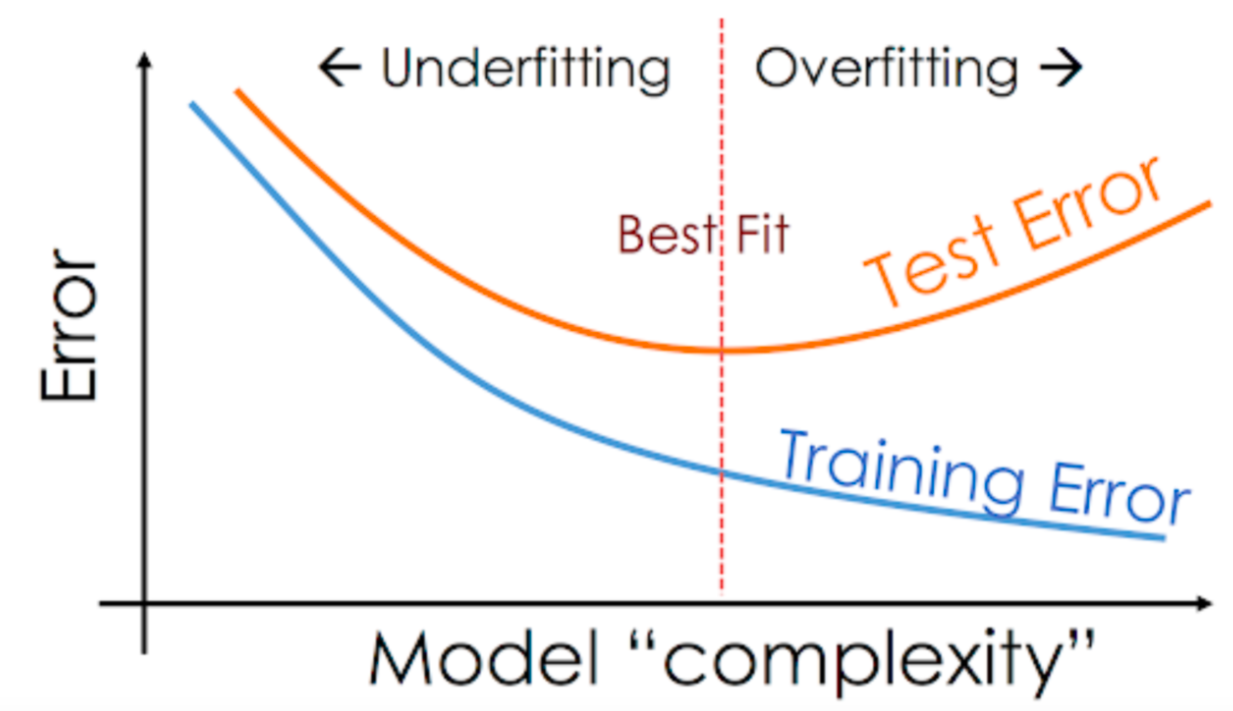

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (22,498), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

# **Upload this Day 12 Colab Notebook to your Github repository under "Day 12" folder. Also add your *Reflection* on today's learning in README.md**

Source: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb